# PointNet Segmentation part
This is a homework based on the paper [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593)

## Dataset

### Download the dataset by wget

In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LxpGXSDOI9V5mc5DGuRlOcbulxZoFohC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1LxpGXSDOI9V5mc5DGuRlOcbulxZoFohC" -O expert_verified.zip && rm -rf /tmp/cookies.txt
!unzip -q expert_verified.zip 

--2023-05-05 01:50:10--  https://docs.google.com/uc?export=download&confirm=t&id=1LxpGXSDOI9V5mc5DGuRlOcbulxZoFohC
Resolving docs.google.com (docs.google.com)... 64.233.188.138, 64.233.188.113, 64.233.188.102, ...
Connecting to docs.google.com (docs.google.com)|64.233.188.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eup60gfsht2af13dnr0mlaj9b7g18fv9/1683251400000/12144501948969093587/*/1LxpGXSDOI9V5mc5DGuRlOcbulxZoFohC?e=download&uuid=1d940545-f5e5-43c2-b4c2-54edcea53e40 [following]
--2023-05-05 01:50:31--  https://doc-10-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/eup60gfsht2af13dnr0mlaj9b7g18fv9/1683251400000/12144501948969093587/*/1LxpGXSDOI9V5mc5DGuRlOcbulxZoFohC?e=download&uuid=1d940545-f5e5-43c2-b4c2-54edcea53e40
Resolving doc-10-4s-docs.googleusercontent.com (doc-10-4s-docs.googleusercontent.com)... 108.177.97.132, 

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yQapyoGEfdBen75MTwh6AD7GRY-UMVZn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yQapyoGEfdBen75MTwh6AD7GRY-UMVZn" -O points.zip && rm -rf /tmp/cookies.txt
!unzip -q points.zip

--2023-05-05 01:50:32--  https://docs.google.com/uc?export=download&confirm=t&id=1yQapyoGEfdBen75MTwh6AD7GRY-UMVZn
Resolving docs.google.com (docs.google.com)... 64.233.188.138, 64.233.188.113, 64.233.188.102, ...
Connecting to docs.google.com (docs.google.com)|64.233.188.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lkm549hsahammvb8f5t95efsm01rduvi/1683251400000/12144501948969093587/*/1yQapyoGEfdBen75MTwh6AD7GRY-UMVZn?e=download&uuid=f2162fc0-efec-4be3-ae11-58f10702aa04 [following]
--2023-05-05 01:50:33--  https://doc-0o-4s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lkm549hsahammvb8f5t95efsm01rduvi/1683251400000/12144501948969093587/*/1yQapyoGEfdBen75MTwh6AD7GRY-UMVZn?e=download&uuid=f2162fc0-efec-4be3-ae11-58f10702aa04
Resolving doc-0o-4s-docs.googleusercontent.com (doc-0o-4s-docs.googleusercontent.com)... 108.177.97.132, 

In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.dataset import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.notebook import trange, tqdm

import plotly.graph_objects as go
import plotly.express as px

### Load the dataset

In [4]:
def read_pts(file):
    verts = np.genfromtxt(file)
    #return utils.cent_norm(verts)
    return verts

def read_seg(file):
    verts = np.genfromtxt(file, dtype= (int))
    return verts

def sample_2000(pts, pts_cat):    
    res1 = np.concatenate((pts,np.reshape(pts_cat, (pts_cat.shape[0], 1))), axis= 1)
    res = np.asarray(random.choices(res1, weights=None, cum_weights=None, k=2000))
    images = res[:, 0:3]
    categories = res[:, 3]
    categories-=np.ones(categories.shape)
    return images, categories

In [5]:
class Data(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, valid=False, transform=None):
        
        self.root_dir = root_dir
        self.files = []
        self.valid=valid

        newdir = root_dir + '/expert_verified/points_label/'

        for file in os.listdir(newdir):
            if file.find("(")!=-1:
                continue
            o = {}
            o['category'] = newdir + file
            o['img_path'] = root_dir + '/points/'+ file.replace('.seg', '.pts')
            self.files.append(o)
       

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        category = self.files[idx]['category']
        with open(img_path, 'r') as f:
            image1 = read_pts(f)
        with open(category, 'r') as f:  
            category1 = read_seg(f)
        image2, category2 = sample_2000(image1, category1)
        if not self.valid:
            theta = random.random()*360
        
        return {'image': np.array(image2, dtype="float32"), 'category': category2.astype(int)}


In [6]:
root_dir="/content"
dset = Data(root_dir , transform=None)
train_num = int(len(dset) * 0.95)
val_num = int(len(dset) *0.05)
if int(len(dset)) - train_num -  val_num >0 :
    train_num = train_num + 1
elif int(len(dset)) - train_num -  val_num < 0:
    train_num = train_num -1
train_dataset, val_dataset = random_split(dset, [train_num, val_num])
val_dataset.valid=True

print('######### Dataset class created #########')
print('Number of images: ', len(dset))
print('Sample image shape: ', dset[0]['image'].shape)

Seg_train_loader = DataLoader(dataset=train_dataset, batch_size=32)
Seg_val_loader = DataLoader(dataset=val_dataset, batch_size=32)

######### Dataset class created #########
Number of images:  2690
Sample image shape:  (2000, 3)


### Visualize item in dataset

In [7]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [8]:
def segpcshow(xs,ys,zs, category):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color=category)),
                      selector=dict(mode='markers'))
    fig.show()

In [9]:
item_visualize = train_dataset[1000] # feel free to change the index to visualize different pointcloud
pointcloud = item_visualize['image']
category = item_visualize['category']
segpcshow(*pointcloud.T, category)

In [10]:
def _set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## Model Sturcture

### Segmentation Model

**Refer the Supplementary C** in [PointNet paper](https://arxiv.org/abs/1612.00593)

The output from the classification global transform section forms a vector [f1 , . . . , fK ], which is a global signature of the input set. We can easily train a SVM or multi-layer perceptron classifier on the shape global features for classification. However, point segmentation requires a combination of local and global knowledge. We implement this by using U-Net-Like structure, concatenate the global and local feature together. The feature in every layer is stacked together to form point feature for every point. The architecture can be seen in the following figure.
The architecture can be seen in the following figure.

![pointnet_segmentation](https://raw.githubusercontent.com/58191554/PointNet-Project/main/Segmentation.pic.jpg)


To get started with implementing PointNet segmentation, we need to change ```Transform``` to ```SegTransform```, ```PointNet``` to ```PointNetSeg``` in order to correspond with the paper implementation.

To accelerate training, we limit the segmentation dataset to only one category(plane). So we simplify the segmentation model by not concentrating the one-hot vector to point feature. As a result, the resulting point feature will only have 3008 dimensions.

HINT: use `Conv1d` to do shared MLP

### T-net part is same as T-net in PointNet classification

In [11]:
class Tnet(nn.Module):
    """
    T-Net is a type of spatial transformer network (STN) that learns a kxk transformation matrix
    for a given point cloud. The matrix is then used to transform the point cloud to a canonical
    pose. It consists of two parts: a convolutional network and a fully connected network.
    The convolutional network maps the input point cloud to a feature space and the fully connected
    network learns the transformation matrix from the feature space.
    """
    def __init__(self, hidden_sizes_conv=[64, 128, 1024], hidden_sizes_fc=[512, 256], k=3):
        super().__init__()
        self.k=k
        self.hidden_sizes_conv=hidden_sizes_conv
        self.hidden_sizes_fc=hidden_sizes_fc
        self.fc1 = nn.Linear(hidden_sizes_fc[-1],k*k)
        self.conv = self._build_conv()
        self.fc = self._build_fc()
  
    def _build_conv(self):
        layers = []
        prev_size = self.k
        for layer_id, size in enumerate(self.hidden_sizes_conv):
            bn = nn.BatchNorm1d(size)
            conv = nn.Conv1d(prev_size, size,1)  #share mlp can be implemented by three 1*1 convolution filter
            layers.append(conv)
            layers.append(bn)
            layers.append(nn.ReLU())
            prev_size = size
        return nn.Sequential(*layers)
  
    def _build_fc(self):
        layers = []
        prev_size = self.hidden_sizes_conv[-1]
        for layer_id, size in enumerate(self.hidden_sizes_fc):
            bn = nn.BatchNorm1d(size)
            fc = nn.Linear(prev_size, size)
            layers.append(fc)
            layers.append(bn)
            layers.append(nn.ReLU())
            prev_size = size
        return nn.Sequential(*layers)
      

    def forward(self, input):

        # input.shape (bs,n,3)
        bs = input.size(0)
        
        xb = self.conv(input)   #3->64->128->1024
        #torch.nn.MaxPool1d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        #bs*n*1024->bs*1024*1
        # print(xb.shape)
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        # print(pool.shape)
        
        flat = nn.Flatten(1)(pool)   #flatten the tensor bs*1*1024->bs*1024 
        #fully connected la m,yer
        #1024->512->256
        xb = self.fc(flat)
      
        #initialize with identity matrix bs*k*k
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
          init=init.cuda()
        #b*256->b*(k*k)->b*k*k + init
        matrix = self.fc1(xb).view(-1,self.k,self.k) + init
        #input b*n*k
        return matrix

### SegTransform, PointNetSeg part

In [12]:
class SegTransform(nn.Module):
    """
    SegTransform is a class transform point cloud into point feature. When the data go through
    the network, the features generated by every layer in the network stack together to form the 
    point features.
    """
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=128)
        self.fc1 = nn.Conv1d(3,64,1)
        self.fc2 = nn.Conv1d(64,128,1) 
        self.fc3 = nn.Conv1d(128,128,1)
        self.fc4 = nn.Conv1d(128,512,1)
        self.fc5 = nn.Conv1d(512,2048,1)

        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(2048)

    def forward(self, input):
        """
        input: bs*3*n tensor
        output:
          outs: List of tensor, contain every output of the fc layer
          matrix3x3: bs*3*3 matrix output by t-net
          matrix128x128: bs*128*128 matrix output by t-net
        """
        #
        n_pts = input.size()[2]
        outs = []
        matrix3x3 = self.input_transform(input)
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        out1 = F.relu(self.bn1(self.fc1(xb)))
        outs.append(out1)
        ########################################################################
        # TODO: Performs the forward pass of the SegTransform. 
        # It is used to generate the point feature that is then feeded into the final MLP part.

        # Hint: Make sure adding batch normarlization layer and relu after every fc layer.
        # Hint: The final return output should be like [out1, out2, out3...].
        # Hint: In order to multiply the t-net output with the input, you need to adjust the shape of the input using torch.transpose function.
        # Hint: The global feature (output after maxpool) is repeated n times to concatenate to every local feature. 
        #       You may find torch.repeat and torch.transpose useful here.
        ########################################################################
        #bs*64*n -> bs*128*n
        out2 = F.relu(self.bn2(self.fc2(out1)))
        outs.append(out2)
        out3 = F.relu(self.bn3(self.fc3(out2)))
        # 128->128
        outs.append(out3)
        #bs*128*128
        matrix128x128 = self.feature_transform(out3)
        #bs*n*128 * bs*128*128 -> bs*n*128 -> bs*128*n
        out4 = torch.bmm(torch.transpose(out3,1,2), matrix128x128).transpose(1,2) 
        outs.append(out4)
        # 128->512
        out5 = F.relu(self.bn4(self.fc4(out4)))
        outs.append(out5)
        #512->2048
        xb = self.bn5(self.fc5(out5))
        #bs*2048*n -> bs*2048*1
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        #bs*2048->n*bs*2048->2048*bs*n->bs*2048*n
        out6 = nn.Flatten(1)(xb).repeat(n_pts,1,1).transpose(0,2).transpose(0,1)#.repeat(1, 1, n_pts)
        outs.append(out6)
        ########################################################################

        return outs, matrix3x3, matrix128x128


class PointNetSeg(nn.Module):
    """
    PointNetSeg is a class transform point feature into scores of each point
    In this dataset the category number is 4
    """
    def __init__(self, hidden_sizes_fc=[256, 256, 128, 4]):
        super().__init__()
        self.transform = SegTransform()
        self.hidden_sizes_fc=hidden_sizes_fc
        self.fc = self._build_fc()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def _build_fc(self):
        layers = []
        prev_size = 3008
        for layer_id, size in enumerate(self.hidden_sizes_fc):
            bn = nn.BatchNorm1d(size)
            fc = nn.Conv1d(prev_size, size, 1)
            layers.append(fc)
            layers.append(bn)
            layers.append(nn.ReLU())
            prev_size = size
        return nn.Sequential(*layers)

    def forward(self, input):
        """
        input: bs*3*n tensor
        output:
          out: logsoftmax score of each point, of shape bs*category_number*n
          matrix3x3: bs*3*3 matrix output by t-net
          matrix128x128: bs*128*128 matrix output by t-net
        """
        inputs, matrix3x3, matrix128x128 = self.transform(input)
        #bs*3008*n
        stack = torch.cat(inputs,1)
        output = self.fc(stack)
        
        return self.logsoftmax(output), matrix3x3, matrix128x128

### Test SegTransform, PointNetSeg

In [13]:
_set_seed(2017)
model = SegTransform()

if count_parameters(model)!=6970057:
    print("Error")
    print("test_t_net parameters number = ", count_parameters(model))

assert count_parameters(model)==6970057

_set_seed(2017)

x1 = torch.randn(3, 3, 5)

y1=torch.tensor([0.2305, 0.1496, 0.0000, 0.2544, 0.0000, 2.1451, 0.0000, 0.0000, 0.9137, 0.0000])

pred_y1, _, _ = model(x1)
print(pred_y1[0].view(-1)[35:45])
assert torch.allclose(y1, pred_y1[0].view(-1)[35:45], rtol=1e-03, atol=1e-03),  "different y_pred and y"
print("SegTransform test pass!")

tensor([0.2305, 0.1496, 0.0000, 0.2544, 0.0000, 2.1451, 0.0000, 0.0000, 0.9137,
        0.0000], grad_fn=<SliceBackward0>)
SegTransform test pass!


In [14]:
_set_seed(2017)
model = PointNetSeg()

if count_parameters(model)!=7840853:
    print("Error")
    print("test_t_net parameters number = ", count_parameters(model))

assert count_parameters(model)==7840853
_set_seed(2017)
x1 = torch.randn(3, 3, 5)

y1=torch.tensor([-0.6844, -2.1168, -2.7130, -1.6787, -1.5990, -1.8179, -1.4520, -1.5434, -1.8525, -1.4774])
pred_y1, _, _ = model(x1)
assert torch.allclose(y1, pred_y1.view(-1)[35:45], rtol=1e-03, atol=1e-03),  "different y_pred and y"
print("PointNetSeg test pass!")

PointNetSeg test pass!


## Training loop for segmentation

In [15]:
class ExperimentSeg:
    def __init__(self, train_data, val_data, model: nn.Module,
                 lr: float, save=True):
        self.train_data = train_data
        self.val_data = val_data
        self.model = model.cuda()
        self.optimizer = torch.optim.Adam(pointnet.parameters(), lr=lr)
        self.save=save
        self.loss=[]
        self.acc=[]

    def train(self, epochs):
        epoch_iterator = trange(epochs)
        # validation
        if self.val_data:
            self.evaluate("Initial ")
        for epoch in epoch_iterator: 
            self.model.eval()
            correct = total = 0
            self.model.train()
            running_loss = 0.0
            data_iterator = tqdm(self.train_data)
            for i, data in enumerate(data_iterator, 0):
                inputs, labels = data['image'].to(device), data['category'].to(device)
                self.optimizer.zero_grad()
                outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))

                loss = self.getloss(outputs, labels, m3x3, m64x64)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 10 == 9:    # print every 10 mini-batches
                    self.loss.append(running_loss / 10)
                    data_iterator.set_postfix(loss=running_loss / 10)
                    running_loss = 0.0
                    
            # validation
            if self.val_data:
                self.evaluate("Epoch:{} ".format(epoch+1))

            # save the model
            if self.save:
                torch.save(self.model.state_dict(), "save_"+str(epoch)+".pth")

    def evaluate(self, ttype):
        self.model.eval()
        correct = total = 0
        with torch.no_grad():
            for data in self.val_data:
                inputs, labels = data['image'].to(device).float(), data['category'].to(device)
                outputs, __, __ = self.model(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0) * labels.size(1)
                correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            self.acc.append(val_acc)
            print(ttype+'Valid accuracy: %d %%' % val_acc)
            #epoch_iterator.set_postfix(val_acc=val_acc)
            
    def getloss(self, outputs, labels, m3x3, m128x128, alpha = 0.0001):
        criterion = torch.nn.NLLLoss()
        bs=outputs.size(0)
        id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
        id128x128 = torch.eye(128, requires_grad=True).repeat(bs,1,1)
        if outputs.is_cuda:
            id3x3=id3x3.cuda()
            id128x128=id128x128.cuda()
        diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
        diff128x128 = id128x128-torch.bmm(m128x128,m128x128.transpose(1,2))
        return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff128x128)) / float(bs)
    
    def plt_loss(self):
      x1 = range(0, len(self.loss))
      y1 = self.loss
      plt.plot(x1, y1, 'o-')
      plt.title('Test loss vs. epoches')
      plt.ylabel('Test loss')
      plt.show()   

    def plt_accuracy(self):
      x1 = range(0, len(self.acc))
      y1 = self.acc
      plt.plot(x1, y1, 'o-')
      plt.title('Validation accuracy vs. epoches')
      plt.ylabel('Validation accuracy')
      plt.show()
  
    def visualize_pred_label(self):
      for data in self.val_data:
          inputs, labels = data['image'].to(device), data['category'].to(device)
          outputs, __, __ = self.model(inputs.transpose(1,2))
          _, predicted = torch.max(outputs.data, 1)
          index=random.randint(0, len(data['image']))
          inputs, labels, predicted = inputs.cpu(), labels.cpu(), predicted.cpu()
          print("True Label visualization:\n")
          segpcshow(*inputs[index].T, labels[index])
          print("Predicted Label visualization:\n")
          segpcshow(*inputs[index].T, predicted[index])
          break

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
pointnet = PointNetSeg()
pointnet.to(device)
segexp = ExperimentSeg(Seg_train_loader, Seg_val_loader, pointnet, 0.001, save=False)
segexp.train(5)

  0%|          | 0/5 [00:00<?, ?it/s]

Initial Valid accuracy: 44 %


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch:1 Valid accuracy: 85 %


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch:2 Valid accuracy: 89 %


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch:3 Valid accuracy: 88 %


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch:4 Valid accuracy: 89 %


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch:5 Valid accuracy: 90 %


### Visualize the result

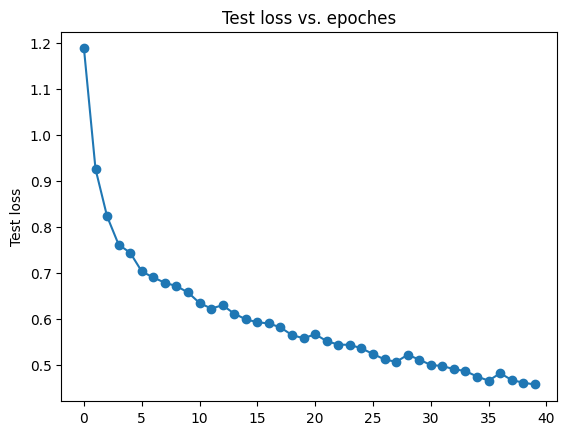

In [18]:
segexp.plt_loss()

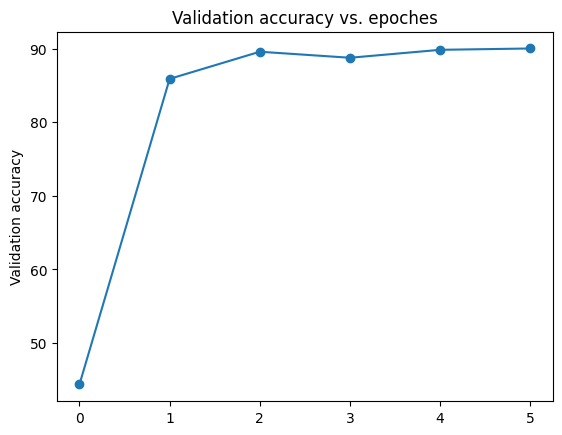

In [19]:
segexp.plt_accuracy()

In [20]:
segexp.visualize_pred_label()

True Label visualization:



Predicted Label visualization:

